In [8]:
%matplotlib widget
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import t, norm
import statsmodels.api as sm 
from sklearn.preprocessing import StandardScaler

np.random.seed(0)



In [9]:
np.random.seed(0)


n_samples = 500
n_features = 5
n_simulations = 3000 # Giảm xuống để chạy nhanh hơn trong ví dụ, có thể tăng lại
std_noise_data = 10


n_signal_features = 2

beta_true_values = np.zeros(n_features) # Đây là các beta cho X1, X2, ..., Xn_features
beta_true_values[0] = 5  # Beta cho X1
beta_true_values[1] = -3 # Beta cho X2
# Beta cho X3, X4, X5 sẽ là 0 (H0 đúng cho chúng)

# Tạo X một lần bên ngoài vòng lặp
X_raw_no_intercept = np.random.normal(0, 1, size=(n_samples, n_features))
X_with_intercept = sm.add_constant(X_raw_no_intercept, prepend=True) # Thêm cột intercept vào X


def create_data_with_signal_ols(X_input_with_intercept, true_betas_with_intercept, std_noise):
    """
    Tạo dữ liệu y cho OLS.
    X_input_with_intercept đã bao gồm cột hằng số.
    true_betas_with_intercept bao gồm giá trị cho intercept ở vị trí đầu tiên.
    """
    n_s = X_input_with_intercept.shape[0] # Sửa tên biến n để tránh xung đột

    linear_component = X_input_with_intercept @ true_betas_with_intercept
    noise = np.random.normal(0, std_noise, size=n_s)
    y = linear_component + noise
    return y

intercept_true = 2
# beta_true_full bao gồm intercept_true, sau đó là beta_true_values (cho X1, X2, ...)
beta_true_full = np.concatenate([[intercept_true], beta_true_values])


def fit_ols_model(X_data_with_intercept, y_data):
    """
    Sử dụng statsmodels.OLS để fit mô hình và lấy beta_hat, p_values.
    """
    model = sm.OLS(y_data, X_data_with_intercept)
    results = model.fit()
    beta_hat_ols = results.params
    p_values_ols = results.pvalues
    return beta_hat_ols, p_values_ols


beta_hat_list = []
p_values_list = []

for i in range(n_simulations):
    if i % 100 == 0:
        print(f"Running simulation {i+1}/{n_simulations}")

    # Sử dụng X_with_intercept đã được tạo sẵn
    current_y = create_data_with_signal_ols(X_with_intercept, beta_true_full, std_noise_data)

    beta_hat, p_values = fit_ols_model(X_with_intercept, current_y)

    beta_hat_list.append(beta_hat)
    p_values_list.append(p_values)


columns_beta = ['Intercept'] + [f'Beta_X{i+1}' for i in range(n_features)]
columns_pvalue = ['P_Intercept'] + [f'P_X{i+1}' for i in range(n_features)]

beta_hat_df = pd.DataFrame(beta_hat_list, columns=columns_beta)
pvalues_df = pd.DataFrame(p_values_list, columns=columns_pvalue)

print("\nTrung bình các Beta_hat ước lượng:")
print(beta_hat_df.mean().round(3))
print("\nBeta_true (bao gồm intercept):")
print(beta_true_full.round(3))

Running simulation 1/3000
Running simulation 101/3000
Running simulation 201/3000
Running simulation 301/3000
Running simulation 401/3000
Running simulation 501/3000
Running simulation 601/3000
Running simulation 701/3000
Running simulation 801/3000
Running simulation 901/3000
Running simulation 1001/3000
Running simulation 1101/3000
Running simulation 1201/3000
Running simulation 1301/3000
Running simulation 1401/3000
Running simulation 1501/3000
Running simulation 1601/3000
Running simulation 1701/3000
Running simulation 1801/3000
Running simulation 1901/3000
Running simulation 2001/3000
Running simulation 2101/3000
Running simulation 2201/3000
Running simulation 2301/3000
Running simulation 2401/3000
Running simulation 2501/3000
Running simulation 2601/3000
Running simulation 2701/3000
Running simulation 2801/3000
Running simulation 2901/3000

Trung bình các Beta_hat ước lượng:
Intercept    2.011
Beta_X1      5.001
Beta_X2     -2.992
Beta_X3      0.008
Beta_X4      0.009
Beta_X5    

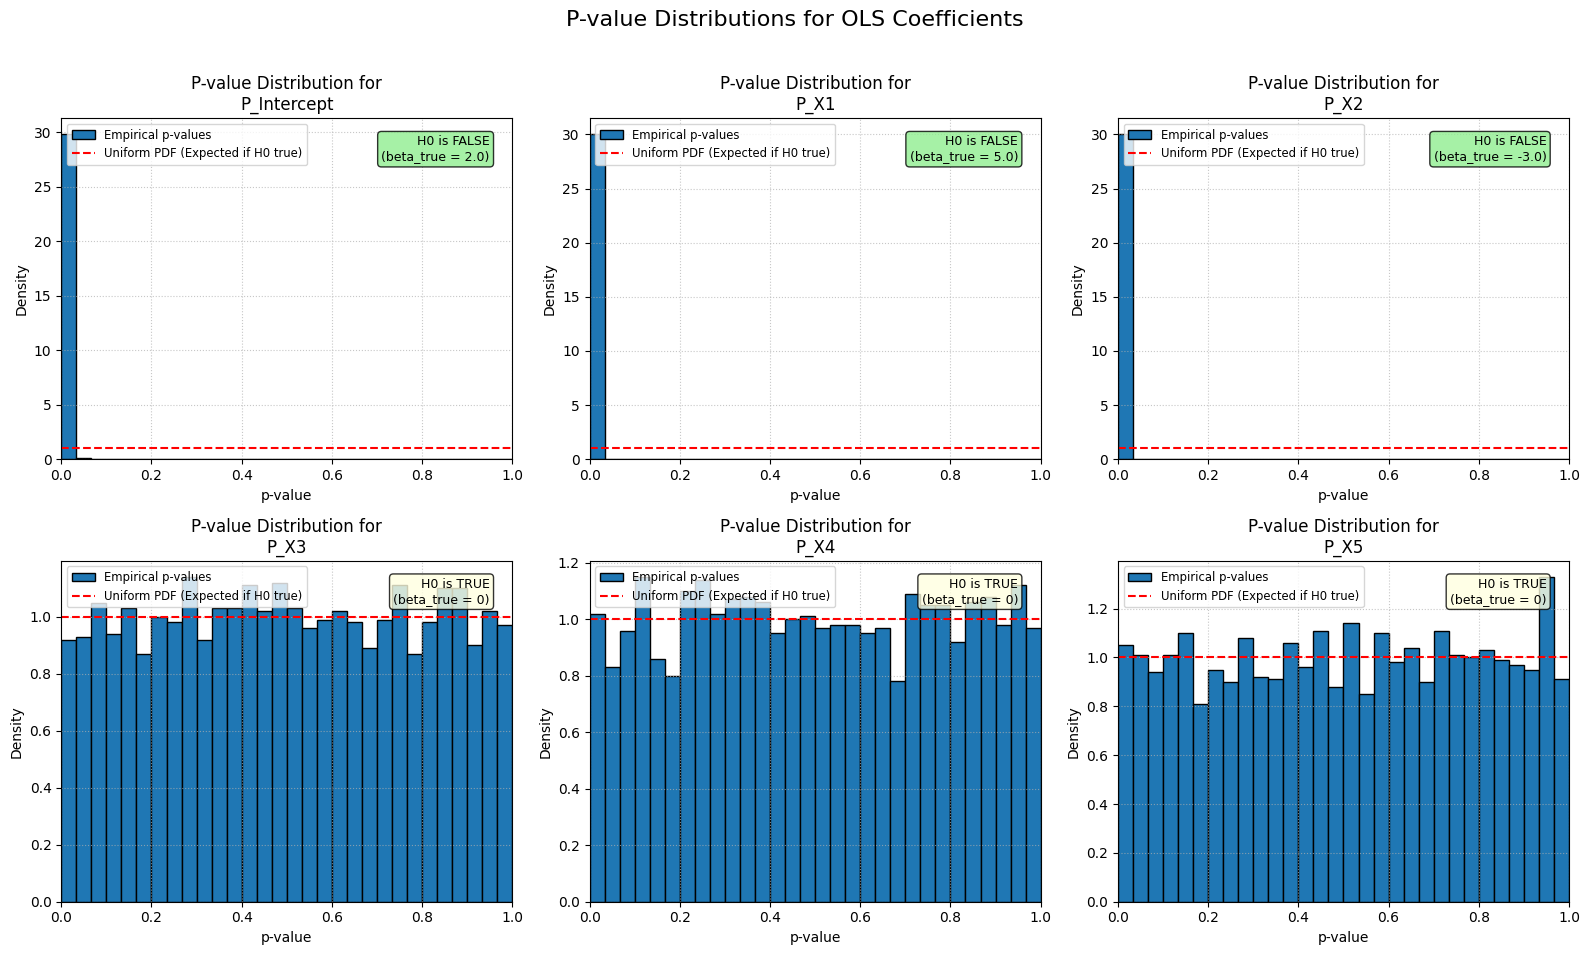

In [10]:
fig_p, axes_p = plt.subplots(2, 3, figsize=(16, 10)) # Tăng nhẹ kích thước
axes_p = axes_p.flatten()

p_value_cols_to_plot = columns_pvalue

for idx, col_name in enumerate(p_value_cols_to_plot):
    if idx < len(axes_p):
        axes_p[idx].hist(pvalues_df[col_name], bins=30, edgecolor='black', density=True, range=(0,1), label='Empirical p-values')
        axes_p[idx].axhline(1, color='red', linestyle='--', label='Uniform PDF (Expected if H0 true)')
        axes_p[idx].set_title(f'P-value Distribution for\n{col_name}') # Xuống dòng cho tiêu đề dài
        axes_p[idx].set_xlabel('p-value')
        axes_p[idx].set_ylabel('Density')
        axes_p[idx].set_xlim(0, 1) # Đảm bảo trục x chỉ từ 0 đến 1
        axes_p[idx].grid(True, linestyle=':', alpha=0.7)

        # Thêm chú thích về H0 đúng hay sai
        true_beta_for_this_coeff = beta_true_full[idx]
        if np.isclose(true_beta_for_this_coeff, 0): # Kiểm tra nếu beta_true gần bằng 0
            axes_p[idx].text(0.95, 0.95, 'H0 is TRUE\n(beta_true = 0)',
                             transform=axes_p[idx].transAxes, fontsize=9,
                             verticalalignment='top', horizontalalignment='right',
                             bbox=dict(boxstyle='round,pad=0.3', fc='lightyellow', alpha=0.8))
        else:
            axes_p[idx].text(0.95, 0.95, f'H0 is FALSE\n(beta_true = {true_beta_for_this_coeff:.1f})',
                             transform=axes_p[idx].transAxes, fontsize=9,
                             verticalalignment='top', horizontalalignment='right',
                             bbox=dict(boxstyle='round,pad=0.3', fc='lightgreen', alpha=0.8))
        axes_p[idx].legend(loc='upper left', fontsize='small')


# Ẩn các subplot không sử dụng
for i in range(len(p_value_cols_to_plot), len(axes_p)):
    fig_p.delaxes(axes_p[i])

plt.tight_layout(rect=[0, 0.03, 1, 0.93]) # Điều chỉnh để tiêu đề không bị che
fig_p.suptitle("P-value Distributions for OLS Coefficients", fontsize=16, y=0.98) # Nâng tiêu đề chính
plt.show()


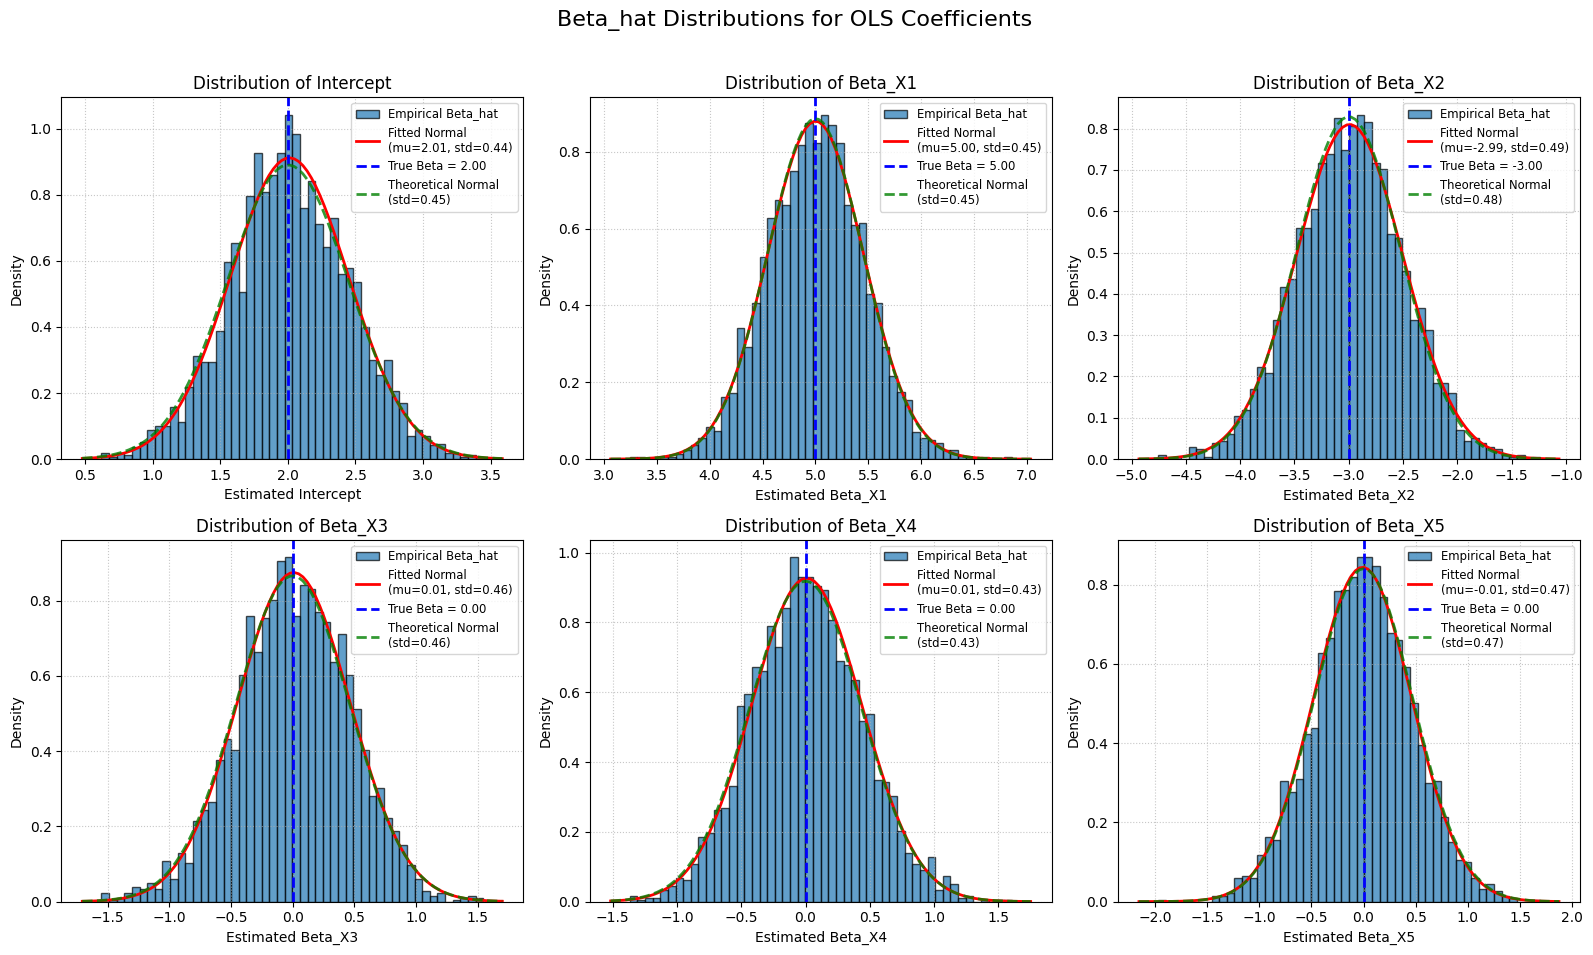

In [11]:
fig_b, axes_b = plt.subplots(2, 3, figsize=(16, 10)) # Tăng nhẹ kích thước
axes_b = axes_b.flatten()

# Tính toán std_each_beta_hat lý thuyết một lần bên ngoài vòng lặp
sigma_squared_true_noise = std_noise_data ** 2
# Sử dụng X_with_intercept để tính var_beta_hat_theoretical
var_beta_hat_theoretical = sigma_squared_true_noise * np.linalg.inv(X_with_intercept.T @ X_with_intercept)
std_each_beta_hat_theoretical = np.sqrt(np.diag(var_beta_hat_theoretical))


for idx, col_name in enumerate(columns_beta):
    if idx < len(axes_b):
        beta_values_for_hist = beta_hat_df[col_name]
        axes_b[idx].hist(beta_values_for_hist, bins=50, density=True, edgecolor='black', alpha=0.7, label='Empirical Beta_hat')

        mu_emp, std_emp = norm.fit(beta_values_for_hist)
        xmin, xmax = axes_b[idx].get_xlim()
        x_norm_emp = np.linspace(xmin, xmax, 100)
        p_norm_emp = norm.pdf(x_norm_emp, mu_emp, std_emp)
        axes_b[idx].plot(x_norm_emp, p_norm_emp, 'r-', linewidth=2, label=f'Fitted Normal\n(mu={mu_emp:.2f}, std={std_emp:.2f})')

        true_val = beta_true_full[idx]
        axes_b[idx].axvline(true_val, color='blue', linestyle='--', linewidth=2, label=f'True Beta = {true_val:.2f}')


        std_theoretical_val = std_each_beta_hat_theoretical[idx]
        p_norm_theory = norm.pdf(x_norm_emp, true_val, std_theoretical_val)
        axes_b[idx].plot(x_norm_emp, p_norm_theory, 'g--', linewidth=2, alpha=0.8, label=f'Theoretical Normal\n(std={std_theoretical_val:.2f})')

        axes_b[idx].set_title(f'Distribution of {col_name}')
        axes_b[idx].set_xlabel(f'Estimated {col_name}')
        axes_b[idx].set_ylabel('Density')
        axes_b[idx].legend(fontsize='small')
        axes_b[idx].grid(True, linestyle=':', alpha=0.7)


for i in range(len(columns_beta), len(axes_b)):
    fig_b.delaxes(axes_b[i])

plt.tight_layout(rect=[0, 0.03, 1, 0.93])
fig_b.suptitle("Beta_hat Distributions for OLS Coefficients", fontsize=16, y=0.98)
plt.show()